In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import and_

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)





In [7]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
results = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
results


('2017-08-23')

In [12]:
# Calculate the date 1 year ago from the last data point in the database
year_ago_date = dt.date(2017,8,23) - dt.timedelta(days=365)
year_ago_date

datetime.date(2016, 8, 23)

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
results = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
    filter(and_(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23'))
results

# Perform a query to retrieve the data and precipitation scores
date = [result[0] for result in results[:]]
precipitation = [result[1] for result in results[:]]


# Save the query results as a Pandas DataFrame and set the index to the date column
weather_df = pd.DataFrame(results[:], columns=['date', 'precipitation'])
weather_df.set_index('date', inplace=True, )
#weather_df = weather_df[weather_df!=0].dropna()
weather_df = weather_df.dropna()
# weather_df = weather_df.groupby(['date']).max()
weather_df

,precipitation
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02


In [14]:
# Sort the dataframe by date


weather_asc_df = weather_df.sort_values(['date'], ascending=True)
weather_asc_df


,precipitation
date,
2016-08-23,0.70
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,1.79
2016-08-23,0.02
...,...
2017-08-22,0.00
2017-08-23,0.45
2017-08-23,0.08


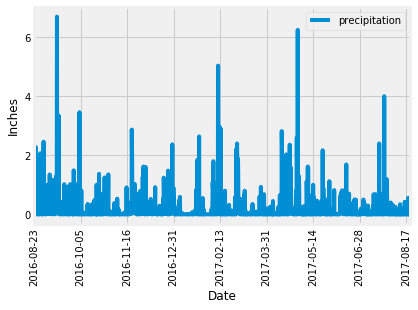

In [15]:

# Use Pandas Plotting with Matplotlib to plot the data


ax = weather_asc_df.plot(rot = 90)

ax.set_xlabel("Date")
ax.set_ylabel("Inches")
#plt.tight_layout()
plt.style.use('fivethirtyeight')
plt.show()



In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
weather_stats = weather_df.describe()
weather_stats

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_stn_stats = session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()
most_active_stn_stats

most_active_stn_stats_df = pd.DataFrame(most_active_stn_stats[:], columns=['Station', 'Low Temp', 'High Temp', 'Avg Temp'])
most_active_stn_stats_df.set_index('Station', inplace=True )
most_active_stn_stats_df

,Low Temp,High Temp,Avg Temp
Station,,,
USC00519281,54.0,85.0,71.663781


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

most_active_stn_temps = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(and_(Measurement.date >= '2016-08-23', Measurement.date <= '2017-08-23')).order_by(Measurement.tobs.asc()).all()


date = [most_active_stn_temps[0] for most_active_stn_temp in most_active_stn_temps[:]]
temp = [most_active_stn_temps[1] for most_active_stn_temp in most_active_stn_temps[:]]

temp_df = pd.DataFrame(most_active_stn_temps[:], columns=['date', 'temp'])
temp_df.set_index('date', inplace=True, )
temp_df = temp_df.dropna()
temp_df = temp_df.groupby(['date']).mean()
temp_df




,temp
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


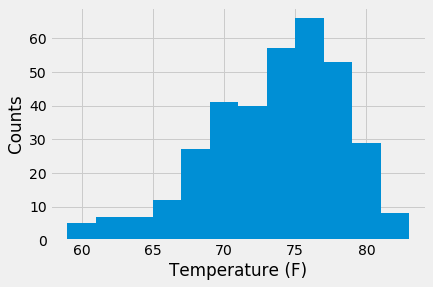

In [21]:
# Plot the results of the data above as a histogram

plt.hist(temp_df['temp'], bins = 12)
plt.xlabel('Temperature (F)')
plt.ylabel('Counts')
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


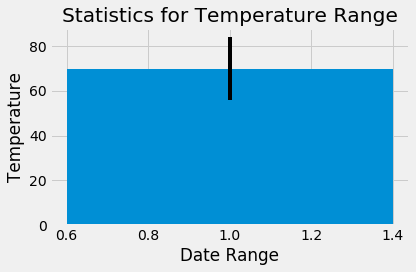

In [68]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

data = calc_temps('2011-02-28', '2011-03-05')[0][1]






errorbar = ((calc_temps('2011-02-28', '2011-03-05')[0][2]) -(calc_temps('2011-02-28', '2011-03-05')[0][0]))

ptps = list(np.ravel(data))

x = 1
plt.bar(x,ptps, yerr=errorbar)

plt.title("Statistics for Temperature Range")
plt.xlabel("Date Range")
plt.ylabel("Temperature")
plt.tight_layout()
plt.show()

In [84]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

combined_station_data = session.query(Measurement.date, Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, ).\
    filter(Measurement.station == Station.station).order_by(Measurement.prcp.desc()).filter(Measurement.date >= '2011-02-28').filter(Measurement.date <= '2011-03-05').all()


combined_station_data

[('2011-03-04',
  1.7,
  'USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('2011-03-04',
  1.45,
  'USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('2011-03-04',
  1.42,
  'USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('2011-03-04',
  1.25,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('2011-03-04',
  1.05,
  'USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6),
 ('2011-03-04',
  0.94,
  'USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('2011-03-03',
  0.89,
  'USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  21.4992,
  -158.0111,
  306.6),
 ('2011-03-04',
  0.88,
  'USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0),
 ('2011-03-03',
  0.69,
  'USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('2011-03-04',
  0.6,
  '

In [86]:
#Not requested but wanted to see data in a dataframe

date = [combined_station_data[0] for combined_station_datum in combined_station_data[:]]
precipitation = [combined_station_data[1] for combined_station_datum in combined_station_data[:]]
stn_id = [combined_station_data[2] for combined_station_datum in combined_station_data[:]]
stn_name = [combined_station_data[3] for combined_station_datum in combined_station_data[:]]
lat = [combined_station_data[4] for combined_station_datum in combined_station_data[:]]
long = [combined_station_data[5] for combined_station_datum in combined_station_data[:]]
elevation = [combined_station_data[6] for combined_station_datum in combined_station_data[:]]

weather_summary_df = pd.DataFrame(combined_station_data[:], columns=['date', 'precipitation', 'stn_id', 'stn_name', 'lat', 'long', 'elevation'])
weather_summary_df


,date,precipitation,stn_id,stn_name,lat,long,elevation
0,2011-03-04,1.70,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
1,2011-03-04,1.45,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,2011-03-04,1.42,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
3,2011-03-04,1.25,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
4,2011-03-04,1.05,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,2011-03-04,0.94,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
6,2011-03-03,0.89,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
7,2011-03-04,0.88,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
8,2011-03-03,0.69,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
9,2011-03-04,0.60,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9


In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [119]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# def holiday_normals(start_date,end_date):
#     """Daily Normals.
    
#     Args:
#         date (str): A date string in the format '%m-%d'
        
#     Returns:
#         A list of tuples containing the daily normals, tmin, tavg, and tmax
    
#     """
list =[daily_normals("02-28"), 
daily_normals("03-01"),  
daily_normals("03-02"),
daily_normals("03-03"), 
daily_normals("03-04"), 
daily_normals("03-05")] 

list

# results2 = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= '02-28').filter(func.strftime("%m-%d", Measurement.date) <= '03-05').all()
# results2


    # Create a dictionary from the row data and append to a list of all_passengers
# weather_data = []
# for tmin, tavg, tmax in results2:
#     date_dict = {}
#     date_dict["tmin"] = tmin
#     date_dict["tavg"] = tavg
#     date_dict["tmax"] = tmax

#     weather_data.append(date_dict)
# weather_data
# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[[(65.0, 70.65517241379311, 80.0)],
 [(64.0, 70.0327868852459, 76.0)],
 [(61.0, 70.36666666666666, 78.0)],
 [(60.0, 70.06896551724138, 78.0)],
 [(57.0, 69.27272727272727, 77.0)],
 [(60.0, 67.89090909090909, 76.0)]]

In [122]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
